# Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Материалы к проекту (файлы):
train.csv
test.csv

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Импорты

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import norm
import random
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing
from sklearn import utils

warnings.filterwarnings('ignore')
%matplotlib inline
# svg не подключаем, так как система не справляется с таким болшим количеством векторной графики.

### Функции

In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [3]:
def distribution_overview(dFrame, attribute, title, scale=0.028, bns=None):
    mean = round(dFrame[attribute].mean(), 2)
    median = dFrame[attribute].median()
    mode = dFrame[attribute].mode()[0]
    min = dFrame[attribute].min()
    max = dFrame[attribute].max()
    q25 = dFrame[attribute].quantile(0.25)
    q75 = dFrame[attribute].quantile(0.95)
    q01 = dFrame[attribute].quantile(0.005)
    q99 = dFrame[attribute].quantile(0.995)

    plt.figure(figsize = (12, 8))
    sns.distplot(dFrame.loc[dFrame[attribute].notnull(), attribute], bins=bns)

    y = np.linspace(0, scale, 100)
    plt.plot([mean]*100, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([median]*100, y, label='median', linestyle='--', linewidth=4)
    plt.plot([mode]*100, y, label='mode', linestyle='-.', linewidth=4)

    plt.title(title)
    plt.legend()

    print(f'min: {min}, quantile 0,01: {q01}, quantile 0,25: {q25}, mean: {mean}, median: {median}, mode: {mode}, quantile 0,75: {q75}, quantile 0,99: {q99}, max: {max}')

    plt.show()

### Описание датасета

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Файло

In [4]:
TRAIN_DATASET_PATH = 'train.csv'

In [5]:
TEST_DATASET_PATH = 'test.csv'

In [6]:
DF_TRAIN_DATASET_PATH = 'df_train.csv'

In [7]:
DF_TEST_DATASET_PATH = 'df_test.csv'

In [8]:
DF_TEST_RESULT_DATASET_PATH = 'df_test_res.csv'

In [9]:
TRAIN_DATASET_PATH_ADD = 'df_add.csv'

In [10]:
TEST_DATASET_PATH_ADD = 'df_test_add.csv'

### Загрузка тренировочного набора

In [11]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Приведение типов данных

In [12]:
df.shape

(10000, 20)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [14]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Количество комнат должно быть целым числом.

In [15]:
df['Rooms'].dtype

dtype('float64')

In [16]:
df['Rooms'] = df['Rooms'].astype('int64')

In [17]:
df['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [18]:
df['HouseFloor'].dtype

dtype('float64')

In [19]:
df['HouseFloor'] = df['HouseFloor'].astype('int64')

In [20]:
df['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [21]:
df['KitchenSquare'].dtype

dtype('float64')

In [22]:
df['KitchenSquare'] = df['KitchenSquare'].astype('int64')

In [23]:
df['KitchenSquare'].dtype

dtype('int64')

### Статистика

In [24]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор количественных переменных

In [25]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


### Обзор номинативных переменных

In [26]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [27]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [28]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [29]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка пропусков

In [30]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**LifeSquare**

Поскольку пустых значений слишком много, то рассмотрим их в зависимости от срезов по количеству комнат и по годам и заполним значениями медианы по этим срезам.

In [31]:
df['Rooms'][df['LifeSquare'].isnull()].value_counts()

1    878
2    828
3    393
4      9
0      3
5      2
Name: Rooms, dtype: int64

In [32]:
df['HouseYear'][df['LifeSquare'].isnull()].value_counts()

1977    1857
2016      64
2017      62
2015      57
2014      42
2018      20
2019       6
2013       4
2012       1
Name: HouseYear, dtype: int64

In [33]:
for room in df['Rooms'][df['LifeSquare'].isnull()].unique():
    for year in df['HouseYear'][df['LifeSquare'].isnull()].unique():
        for floor in df['HouseFloor'][df['LifeSquare'].isnull()].unique():
            df.loc[df['LifeSquare'].isnull() & (df['Rooms'] == room) & (df['HouseYear'] == year) & (df['HouseFloor'] == floor), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull() & (df['Rooms'] == room) & (df['HouseYear'] == year) & (df['HouseFloor'] == floor)].median()

In [34]:
for room in df['Rooms'][df['LifeSquare'].isnull()].unique():
    for year in df['HouseYear'][df['LifeSquare'].isnull()].unique():
        df.loc[df['LifeSquare'].isnull() & (df['Rooms'] == room) & (df['HouseYear'] == year), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull() & (df['Rooms'] == room) & (df['HouseYear'] == year)].median()

In [35]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull()].median()

**Healthcare_1**

"Раскидаем" пустые значения по имеющимся классам значений

Получим уникальные значения из выборки

In [36]:
values = list(df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'].unique())

In [37]:
values = sorted(values)

In [38]:
length = len(values)

In [39]:
length

79

In [40]:
values[:5]

[0.0, 30.0, 32.0, 35.0, 46.0]

In [41]:
values[length - 5:]

[4087.0, 4129.0, 4508.0, 4702.0, 4849.0]

In [42]:
b = df.loc[df['Healthcare_1'].isnull()]

In [43]:
for id in b['Id']:
    df.loc[df['Id'] == id, 'Healthcare_1'] = values[random.randint(0, length - 1)]

**Ecology_2**

In [44]:
df['Ecology_2'].mode()[0]

'B'

In [45]:
df.replace({'Ecology_2': {'-':df['Ecology_2'].mode()[0]}}, inplace=True)

In [46]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

**Ecology_3**

In [47]:
df['Ecology_3'].mode()[0]

'B'

In [48]:
df.replace({'Ecology_3': {'-':df['Ecology_3'].mode()[0]}}, inplace=True)

In [49]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

**Shops_2**

In [50]:
df['Shops_2'].mode()[0]

'B'

In [51]:
df.replace({'Shops_2': {'-':df['Shops_2'].mode()[0]}}, inplace=True)

In [52]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

In [53]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,39.495823,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1255.728300,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,77.151686,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1121.947421,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,23.811124,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,35.704183,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1015.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,47.015242,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1894.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Почти все признаки имеют выбросы.

In [54]:
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,B,B,33,7976,5,990.0,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3,80.384479,46.683720,12,5,17,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2,62.254114,37.160377,7,3,5,1960,0.460556,B,B,20,4386,14,200.0,1,5,B,296021.204377
7,11993,74,2,80.312926,37.038420,0,14,0,1977,0.075779,B,B,6,1437,3,4849.0,0,2,B,221244.156664
8,5172,1,2,64.511437,61.478074,1,9,17,1977,0.007122,B,B,1,264,0,3855.0,0,1,B,229102.795999
9,8649,23,1,46.461409,18.915552,8,13,17,2014,0.075779,B,B,6,1437,3,2620.0,0,2,B,95380.220993


In [55]:
df.tail(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9990,15233,1,3,57.373889,39.688445,5,2,5,1962,0.036270,B,B,6,1318,1,200.0,1,1,B,163807.542987
9991,11553,3,3,101.622794,51.628780,12,18,17,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.501504
9992,14333,150,3,78.249637,49.385096,10,5,16,1976,0.300323,B,B,52,10311,6,4129.0,1,9,B,342418.758888
9993,48,13,3,80.631333,48.899083,10,11,14,1999,0.090799,B,B,74,19083,2,1046.0,5,15,B,350684.628560
9994,4158,23,2,64.864198,61.478074,1,17,17,1977,0.075779,B,B,6,1437,3,1575.0,0,2,B,171323.515653
9995,77,32,2,50.401785,30.476203,5,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1,41.521546,20.539216,9,13,13,2000,0.000000,B,B,30,5562,0,2300.0,0,5,A,189050.289571
9997,5123,27,1,47.939008,48.696782,1,12,16,2015,0.072158,B,B,2,629,1,1015.0,0,0,A,159143.805370
9998,5400,75,2,43.602562,33.840147,8,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1,38.666645,21.157874,8,7,17,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


**HouseYear**

In [56]:
df.sort_values(by="HouseYear", inplace=True)

In [57]:
df['HouseYear'].value_counts().head(11)

1977    2652
2017     308
2016     305
2015     299
2014     210
1970     194
1969     190
1972     178
1971     177
2018     175
1974     169
Name: HouseYear, dtype: int64

In [58]:
df['HouseYear'].head()

9317    1910
2656    1912
5111    1912
910     1914
7611    1916
Name: HouseYear, dtype: int64

In [59]:
df['HouseYear'].tail()

7076        2020
5701        2020
1499        2020
4189        4968
1497    20052011
Name: HouseYear, dtype: int64

In [60]:
df.replace({'HouseYear': {4968:1968}}, inplace=True)

In [61]:
df.replace({'HouseYear': {20052011:2005}}, inplace=True)

**Rooms**

In [62]:
df.sort_values(by="Rooms", inplace=True)

In [63]:
df['Rooms'].unique()

array([ 0,  1,  2,  3,  4,  5,  6, 10, 19], dtype=int64)

In [64]:
df.loc[df['Rooms'].notnull(), 'Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

Убираем 0, 10, 6, 19.

In [65]:
df.loc[df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8834,9443,27,0,87.762616,85.125471,0,5,15,1977,0.211401,B,B,9,1892,0,1937.0,0,1,B,219281.918007
1397,12638,27,0,138.427694,136.215499,0,4,3,2016,0.075424,B,B,11,3097,0,645.0,0,0,B,268394.744389
3911,770,28,0,49.483501,35.704183,0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6149,3159,88,0,38.697117,19.345131,9,9,16,1982,0.127376,B,B,43,8429,3,2890.0,3,9,B,158998.110646
1981,7917,27,0,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,1575.0,0,1,B,302211.260887
2269,7317,27,0,41.790881,0.873147,0,13,0,1977,0.211401,B,B,9,1892,0,1130.0,0,1,B,98129.976788
4366,456,6,0,81.491446,0.873147,0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0,2.377248,0.873147,0,1,0,1977,0.017647,B,B,2,469,0,1940.0,0,0,B,126596.941798


In [66]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] < 45.0), 'Rooms'] = 1

In [67]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(45.0, 65.0), 'Rooms'] = 2

In [68]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(65.0, 85.0), 'Rooms'] = 3

In [69]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(85.0, 105.0), 'Rooms'] = 4

In [70]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] > 106), 'Rooms'] = 5

In [71]:
df.loc[df['Rooms'] == 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2170,14003,99,6,59.414334,38.702244,6,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


In [72]:
df.loc[df['Id'] == 14003, 'Rooms'] = 2

In [73]:
df.loc[df['Rooms'] == 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8849,14865,9,10,60.871266,38.420681,10,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
377,5927,57,10,59.056975,36.223072,10,22,22,2002,0.090799,B,B,74,19083,2,80.0,5,15,B,317265.323792


In [74]:
df.loc[df['Rooms'] == 10, 'Rooms'] = 2

In [75]:
df.loc[df['Rooms'] == 19]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1454,8491,1,19,42.006046,21.779288,7,17,17,2014,0.007122,B,B,1,264,0,262.0,0,1,B,78364.616704


In [76]:
df.loc[df['Rooms'] == 19, 'Rooms'] = 1

**HouseFloor**

In [77]:
df.sort_values(by="HouseFloor", inplace=True)

In [78]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6299,2835,74,1,34.105832,37.976027,0,3,0,1977,0.075779,B,B,6,1437,3,125.0,0,2,B,129203.965386
5225,2597,169,1,43.257138,37.976027,0,5,0,1977,0.178917,B,B,18,3594,4,192.0,1,5,B,226053.135229
2102,1539,6,2,55.084228,37.038420,0,12,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,146456.645948
223,4622,27,2,62.153994,36.094352,0,5,0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,194091.992560
9199,8755,62,2,79.329878,37.038420,0,17,0,1977,0.072158,B,B,2,629,1,628.0,0,0,A,202549.009085


In [79]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2781,1674,76,2,74.344672,41.044132,5,42,48,2016,0.000000,B,B,7,1660,39,1786.0,1,5,B,411691.504766
7728,7453,24,3,126.621358,62.455481,12,22,48,2011,0.111627,B,B,50,12238,8,1970.0,2,3,B,179396.521035
6131,10806,5,1,51.944587,48.709601,1,6,99,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515
8599,9300,74,2,71.747869,74.579809,9,5,99,1977,0.075779,B,B,6,1437,3,1994.0,0,2,B,243329.912579
8854,78,30,2,65.773749,66.811789,1,8,117,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520


In [80]:
df.loc[df['Id'] == 9300, 'HouseFloor'] = 9

In [81]:
df.loc[df['Id'] == 10806, 'HouseFloor'] = 9

In [82]:
df.loc[df['Id'] == 78, 'HouseFloor'] = 17

**Square**

In [83]:
df.sort_values(by="Square", inplace=True)

In [84]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6392,14786,1,1,1.136859,4.525736,1,3,1,1977,0.007122,B,B,1,264,0,35.0,0,1,B,181434.825589
8283,15744,34,1,1.988943,2.642219,1,21,4,1977,0.069753,B,B,53,13670,4,3855.0,1,11,B,458378.777006
4853,3224,27,1,2.377248,0.873147,0,1,0,1977,0.017647,B,B,2,469,0,1940.0,0,0,B,126596.941798
1608,10202,6,1,2.596351,4.604943,1,3,25,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
9294,6782,45,1,2.954309,5.257278,1,3,1,1977,0.195781,B,B,23,5212,6,46.0,3,2,B,438005.182323


In [85]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,5,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,1575.0,0,1,B,302211.260887
1982,5548,86,5,275.645284,233.949309,26,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4690,2307,102,1,409.425181,410.639749,10,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
4262,28,9,2,604.705972,63.611892,1,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
6977,11602,30,2,641.065193,638.163193,10,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


In [86]:
df = df.drop(df[df['Square'] > 250].index)

In [87]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7201,3233,129,4,186.692602,87.487080,32,3,3,2011,0.020741,B,B,24,5613,5,1340.0,2,5,B,423443.464367
652,3718,56,3,190.857689,107.376164,19,7,3,2007,0.000000,B,B,23,5067,4,192.0,2,6,B,338644.075979
8511,4249,23,5,198.930182,123.139863,10,1,2,2011,0.014073,B,B,2,475,0,800.0,0,0,B,345665.209100
9910,16568,27,4,200.334539,201.627361,25,1,2,2013,0.041116,B,B,53,14892,4,810.0,1,4,B,528560.506016
1981,7917,27,5,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,1575.0,0,1,B,302211.260887


**LifeSquare**

In [88]:
df.sort_values(by="LifeSquare", inplace=True)

In [89]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9910,16568,27,4,200.334539,201.627361,25,1,2,2013,0.041116,B,B,53,14892,4,810.0,1,4,B,528560.506016
1981,7917,27,5,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,1575.0,0,1,B,302211.260887
590,14990,23,2,48.449873,263.542020,5,6,5,1972,0.075779,B,B,6,1437,3,900.0,0,2,B,141780.231857
8437,15886,85,3,78.059331,461.463614,10,12,16,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
4328,16550,27,3,81.694417,7480.592129,1,9,17,2016,0.017647,B,B,2,469,0,2301.0,0,0,B,217357.492366


In [90]:
df = df.drop(df[df['LifeSquare'] > 250].index)

In [91]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8913,2603,30,3,162.587886,164.526757,0,2,3,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207407.352593
3651,5300,30,3,169.509941,170.713651,1,2,2,2018,0.000078,B,B,22,6398,141,1046.0,3,23,B,200800.673767
1641,11055,151,1,174.649522,174.837082,15,10,12,1958,0.236108,B,B,16,3893,27,32.0,3,10,B,232766.187698
9910,16568,27,4,200.334539,201.627361,25,1,2,2013,0.041116,B,B,53,14892,4,810.0,1,4,B,528560.506016
1981,7917,27,5,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,1575.0,0,1,B,302211.260887


**KitchenSquare**

In [92]:
df.sort_values(by="KitchenSquare", inplace=True)

In [93]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4651,12552,58,3,116.405693,113.109653,112,3,3,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.936689
2969,7441,62,3,114.734473,112.589083,112,3,3,2015,0.072158,B,B,2,629,1,1145.0,0,0,A,315245.521059
9895,2737,27,3,123.430072,125.806981,123,5,10,2015,0.017647,B,B,2,469,0,1015.0,0,0,B,234194.837047
8584,14679,81,1,32.276663,19.278394,1970,6,1,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275
1064,14656,62,1,47.100719,46.447960,2014,4,1,2014,0.072158,B,B,2,629,1,4087.0,0,0,A,108337.484207


In [94]:
df = df.drop(df[df['KitchenSquare'] > 250].index)

In [95]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7088,6569,27,1,38.220258,18.716856,84,4,17,2018,0.011654,B,B,4,915,0,1046.0,0,0,B,99079.960518
2916,12390,72,3,97.490674,99.323558,96,22,25,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
4651,12552,58,3,116.405693,113.109653,112,3,3,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.936689
2969,7441,62,3,114.734473,112.589083,112,3,3,2015,0.072158,B,B,2,629,1,1145.0,0,0,A,315245.521059
9895,2737,27,3,123.430072,125.806981,123,5,10,2015,0.017647,B,B,2,469,0,1015.0,0,0,B,234194.837047


### Отбор и построение новых признаков

In [96]:
df.sort_values(by="Id", inplace=True)

In [97]:
# df.loc[df['Price'].notnull(), 'Square_Price'] = df.loc[df['Price'].notnull(), 'Square'] / df.loc[df['Price'].notnull(), 'Price']

In [98]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')], axis=1)

In [99]:
df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3')], axis=1)

In [100]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)

In [101]:
# df.drop(['Id'],axis=1,inplace=True)

In [102]:
df.drop(['Ecology_2'],axis=1,inplace=True)

In [103]:
df.drop(['Ecology_3'],axis=1,inplace=True)

In [104]:
df.drop(['Shops_2'],axis=1,inplace=True)

In [105]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
7885,0,0,1,109.144492,84.613939,15,6,15,2011,0.319809,...,2857.0,5,8,289034.391871,0,1,0,1,0,1
5549,2,2,1,34.472263,16.069376,5,5,18,1969,0.000000,...,2715.0,2,5,174548.966339,0,1,0,1,0,1
4808,5,5,3,57.607965,38.955672,5,3,9,1974,0.150818,...,2643.0,4,5,258091.883679,0,1,0,1,0,1
4447,6,6,1,42.466813,40.010160,1,14,17,2014,0.243205,...,540.0,0,0,127196.762031,0,1,0,1,0,1
2684,10,6,3,75.888156,78.324716,1,11,17,2014,0.243205,...,540.0,0,0,218500.747041,0,1,0,1,0,1


In [106]:
train_add = df[:]

### Анализ целевой переменной

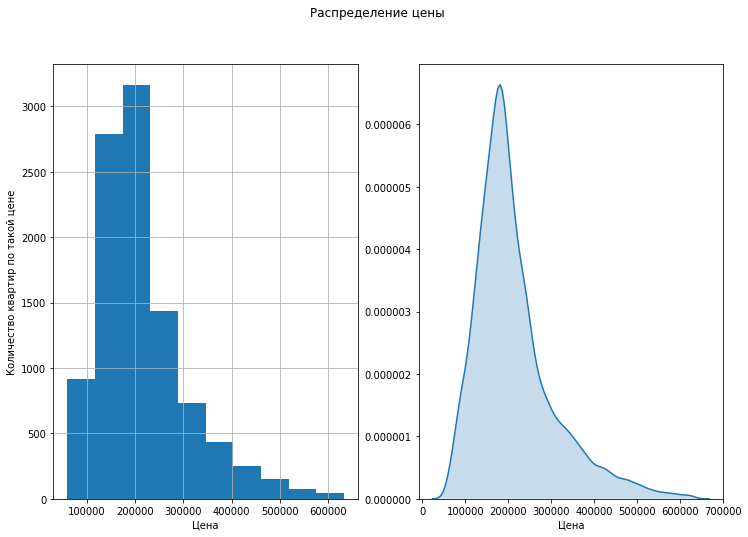

In [107]:
plt.figure(figsize = (12, 8))

plt.subplot(121)
df['Price'].hist()
plt.ylabel('Количество квартир по такой цене')
plt.xlabel('Цена')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Цена')

plt.suptitle('Распределение цены')
plt.show()

Почти идеальное нормальное распределение.

In [108]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

target_mean, target_median, target_mode

(214148.17, 192302.75194072496, 59174.77802758122)

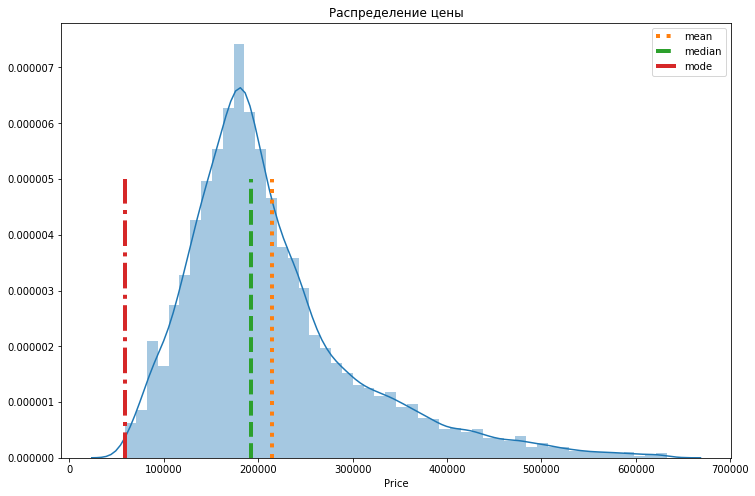

In [109]:
plt.figure(figsize = (12, 8))

sns.distplot(df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()
plt.show()

### Анализ признаков

In [110]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])

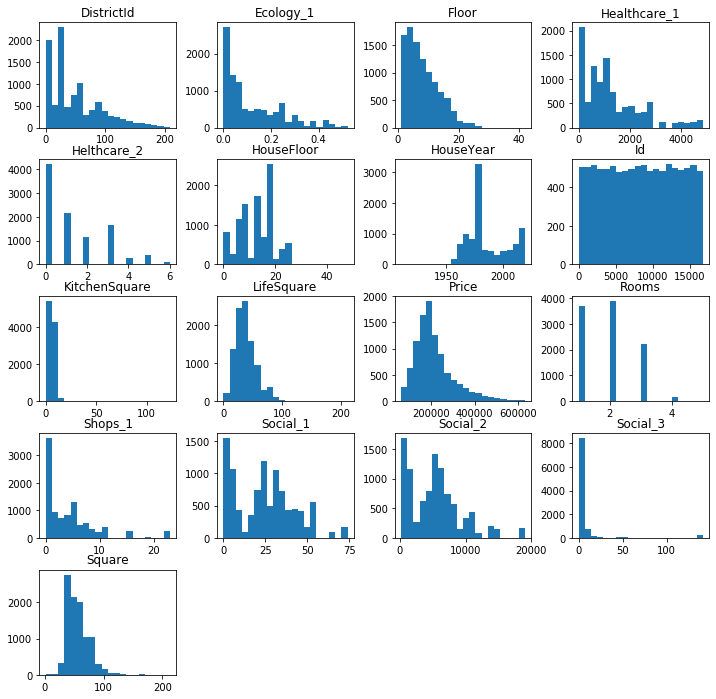

In [111]:
df_num_features.hist(figsize=(12,12), bins=20, grid=False);

In [112]:
# sns.pairplot(df_num_features);

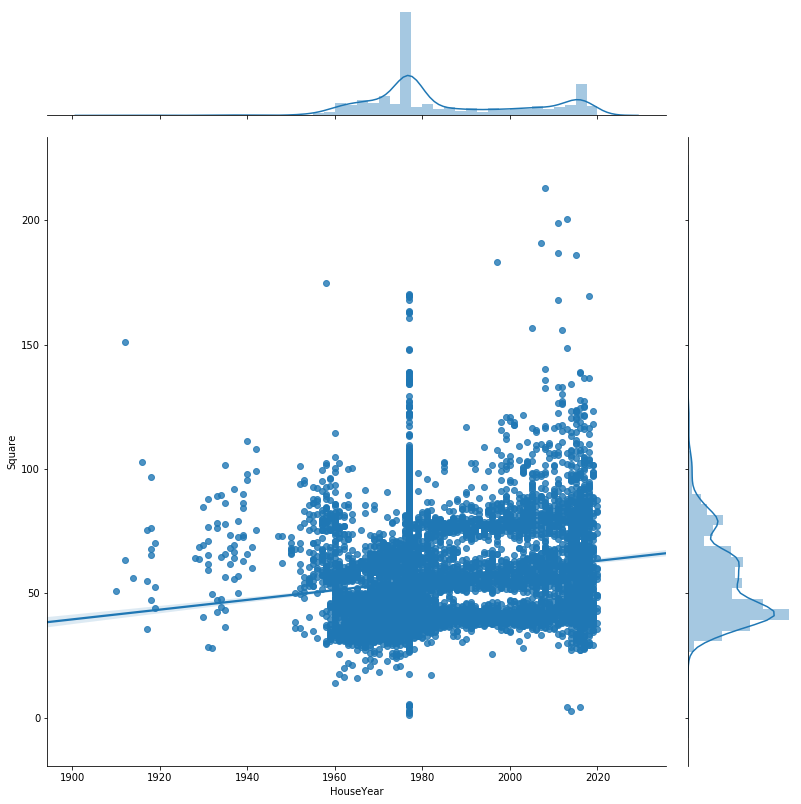

In [113]:
grid = sns.jointplot(df_num_features['HouseYear'], df_num_features['Square'], kind='reg')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

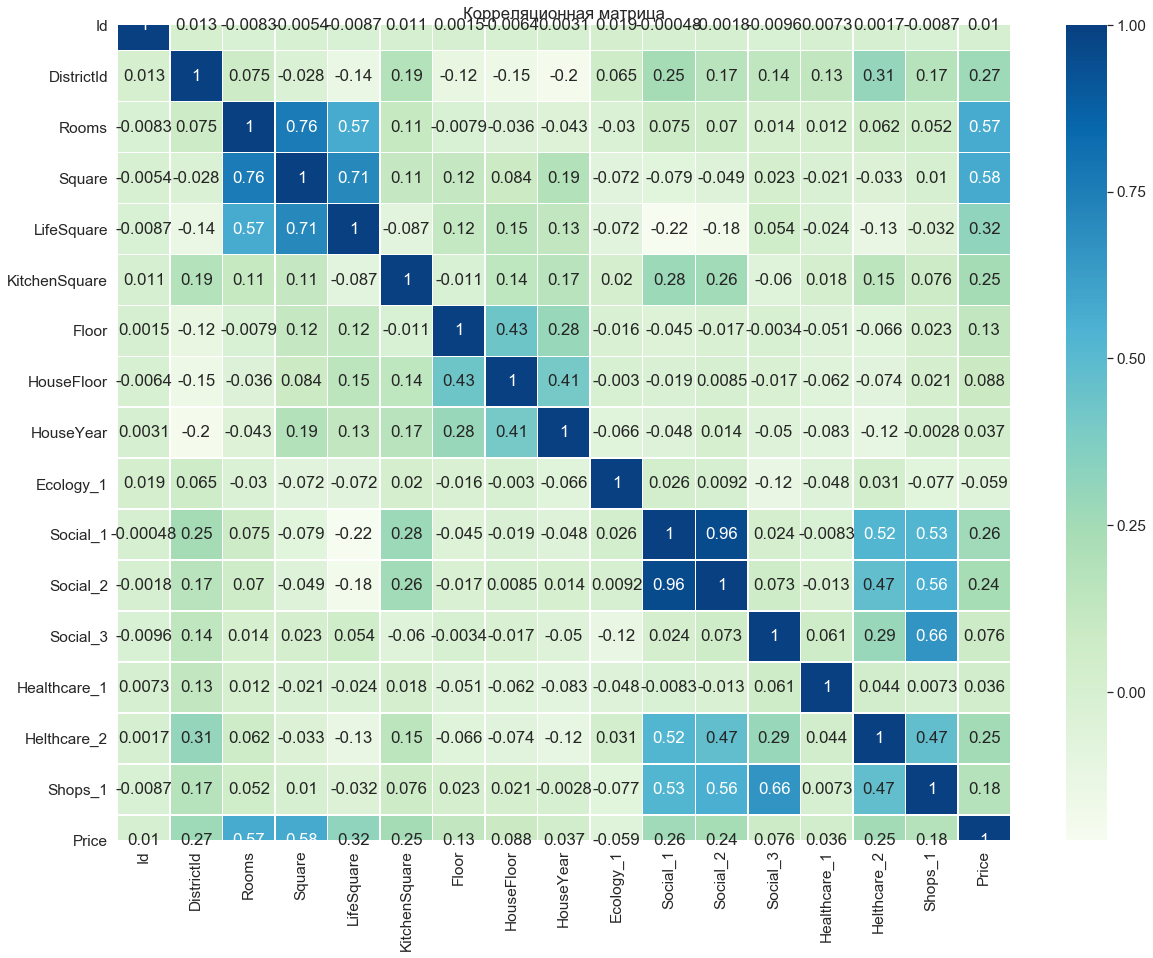

In [114]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_num_features.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

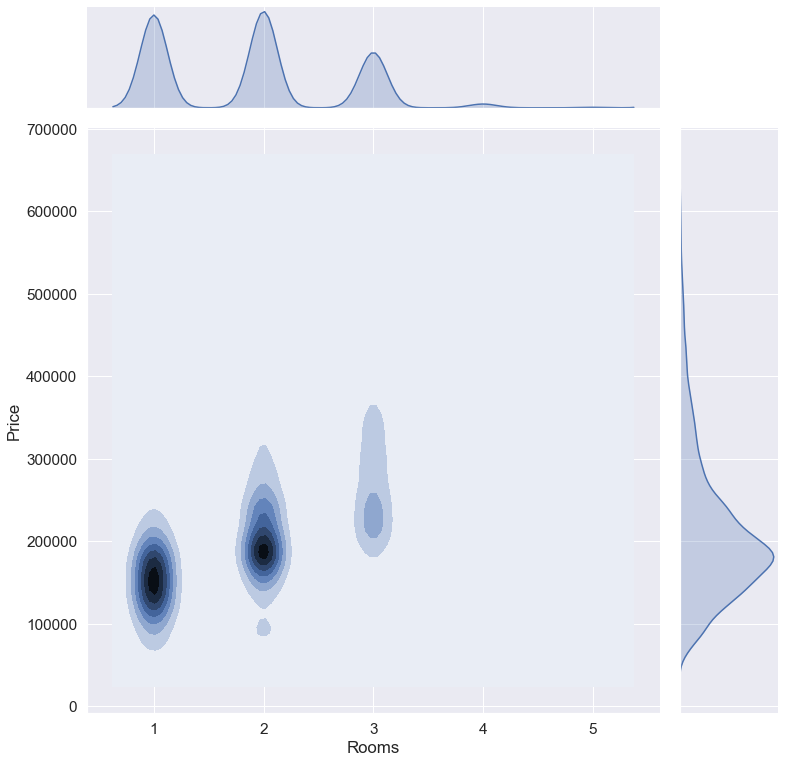

In [115]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

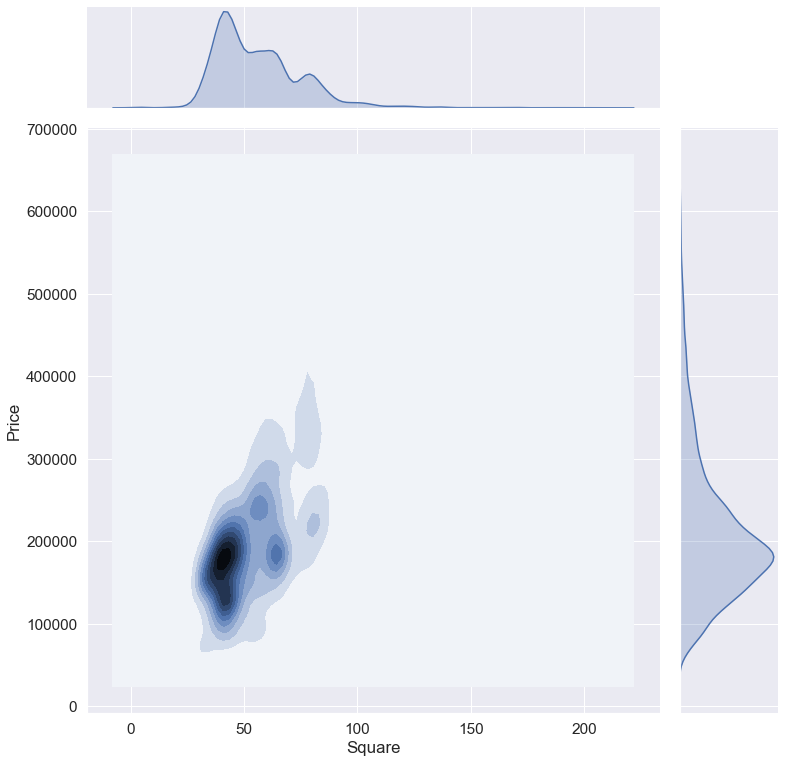

In [116]:
grid = sns.jointplot(df['Square'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

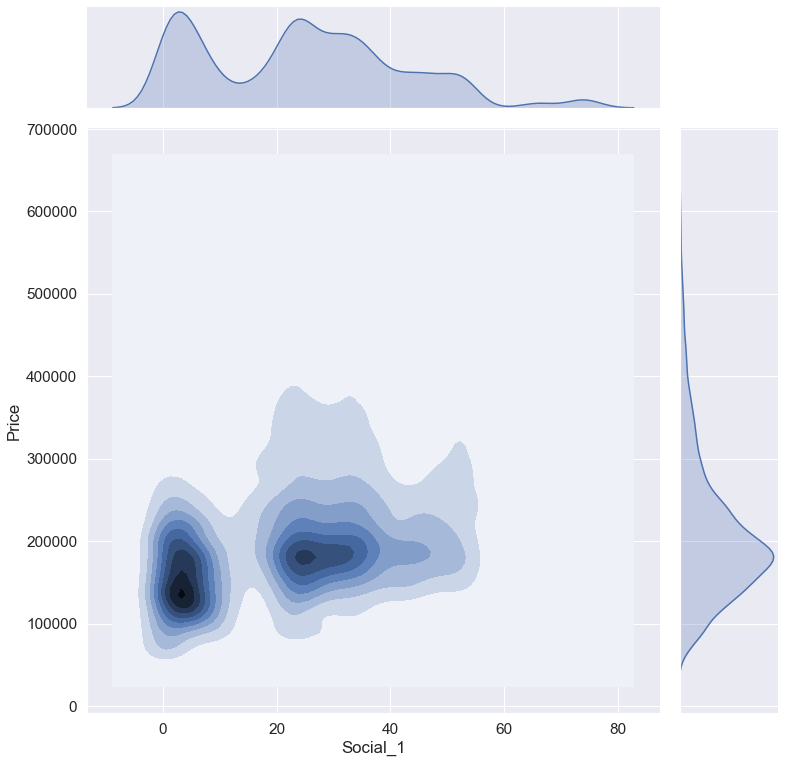

In [117]:
grid = sns.jointplot(df['Social_1'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

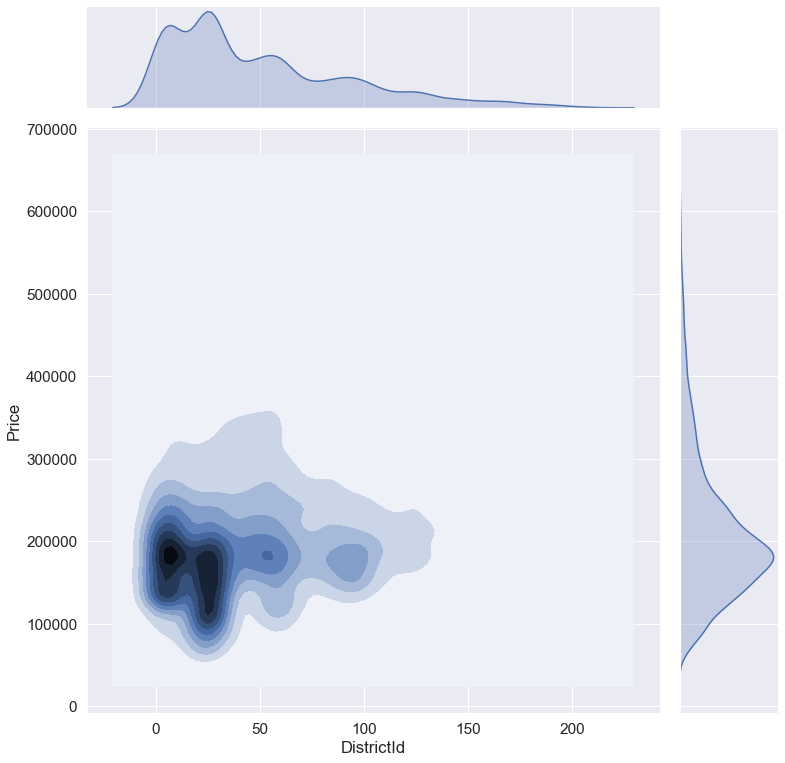

In [118]:
grid = sns.jointplot(df['DistrictId'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

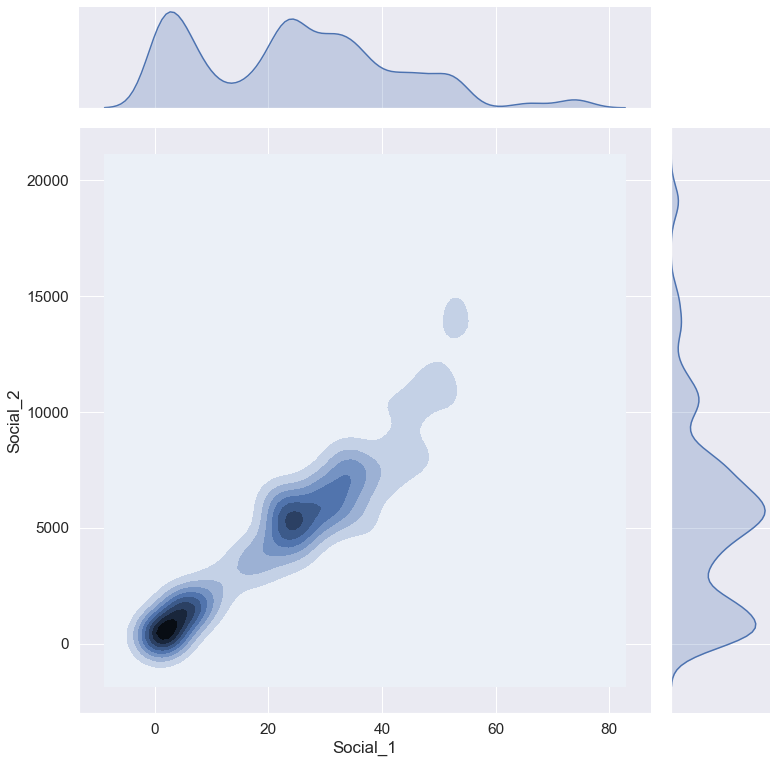

In [119]:
grid = sns.jointplot(df['Social_1'], df['Social_2'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

### Отбор признаков

In [120]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [121]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']
target_name = 'Price'

In [122]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
7885,0,1,109.144492,15,6,15,0.319809,25,4756,16,5,8,0,1,0,1,0,1,289034.391871
5549,2,1,34.472263,5,5,18,0.000000,33,7425,1,2,5,0,1,0,1,0,1,174548.966339
4808,5,3,57.607965,5,3,9,0.150818,16,3433,4,4,5,0,1,0,1,0,1,258091.883679
4447,6,1,42.466813,1,14,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1,127196.762031
2684,6,3,75.888156,1,11,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1,218500.747041


### Стандартизация признаков

In [123]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1']

In [124]:
# scaler = StandardScaler()
# stand_features = scaler.fit_transform(df[feature_names_for_stand])
stand_features = df

In [125]:
stand_features

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
7885,0,1,109.144492,15,6,15,0.319809,25,4756,16,5,8,0,1,0,1,0,1,289034.391871
5549,2,1,34.472263,5,5,18,0.000000,33,7425,1,2,5,0,1,0,1,0,1,174548.966339
4808,5,3,57.607965,5,3,9,0.150818,16,3433,4,4,5,0,1,0,1,0,1,258091.883679
4447,6,1,42.466813,1,14,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1,127196.762031
2684,6,3,75.888156,1,11,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1,218500.747041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,53,1,33.258974,6,6,12,0.313925,22,4625,11,2,10,0,1,0,1,0,1,201307.933649
2457,29,2,45.280336,5,8,8,0.069660,31,6119,4,1,2,0,1,0,1,0,1,239503.727371
659,46,1,33.013935,6,4,9,0.188784,31,6137,4,0,1,0,1,0,1,0,1,168233.016477
4768,94,3,77.325275,10,7,16,0.282798,33,8667,2,0,6,0,1,0,1,0,1,354690.491271


In [126]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [127]:
df.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
7885,0,1,109.144492,15,6,15,0.319809,25,4756,16,5,8,0,1,0,1,0,1,289034.391871
5549,2,1,34.472263,5,5,18,0.000000,33,7425,1,2,5,0,1,0,1,0,1,174548.966339
4808,5,3,57.607965,5,3,9,0.150818,16,3433,4,4,5,0,1,0,1,0,1,258091.883679
4447,6,1,42.466813,1,14,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1,127196.762031
2684,6,3,75.888156,1,11,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1,218500.747041


### Сохранение обучающего датасета

In [128]:
df.to_csv(TRAIN_DATASET_PATH_ADD, index=False, encoding='utf-8')

### Разбиение на train и test

In [129]:
X = df[feature_names]
y = df[target_name]

In [130]:
len(X) - X.count()

DistrictId       0
Rooms            0
Square           0
KitchenSquare    0
Floor            0
HouseFloor       0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Ecology_2_A      0
Ecology_2_B      0
Ecology_3_A      0
Ecology_3_B      0
Shops_2_A        0
Shops_2_B        0
dtype: int64

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение базовых моделей и выбор лучшей

**Linear Regression**

In [132]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.534
MAE:	43593.128
MSE:	3921645130.046


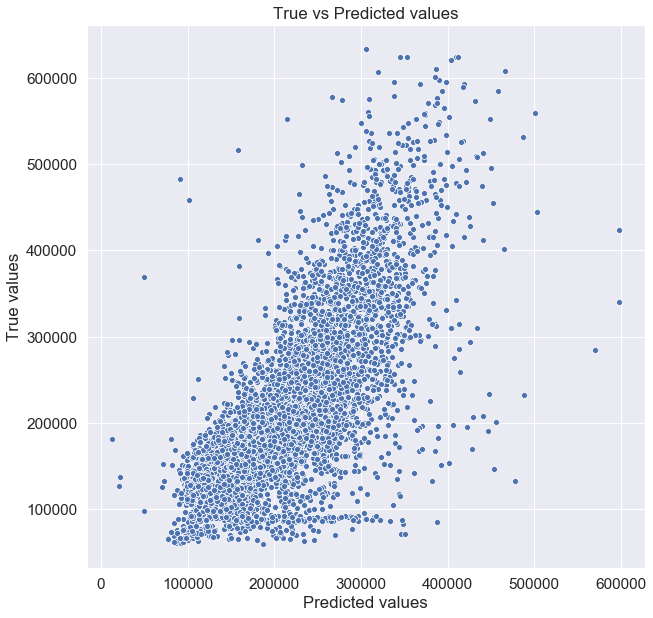

In [133]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [134]:
# sorted(y_train_preds)

R2:	0.52
MAE:	45297.275
MSE:	4337742905.388


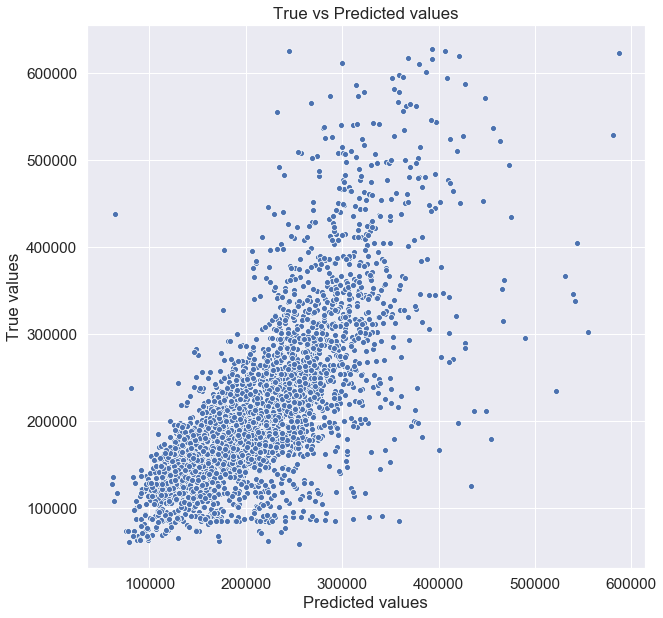

In [135]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [136]:
y_test_preds

array([196943.08978461, 315680.59986561, 252055.1157572 , ...,
       209065.05223326, 178563.61833095, 222567.01913748])

In [137]:
lasso_model = Lasso(alpha=0.3)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

R2:	0.534
MAE:	43593.061
MSE:	3921645152.024


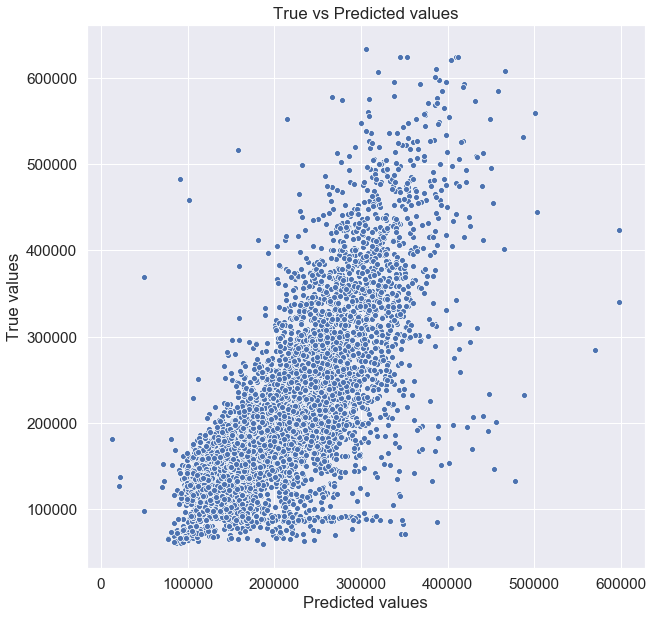

In [138]:
y_train_preds = lasso_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.52
MAE:	45297.031
MSE:	4337737295.773


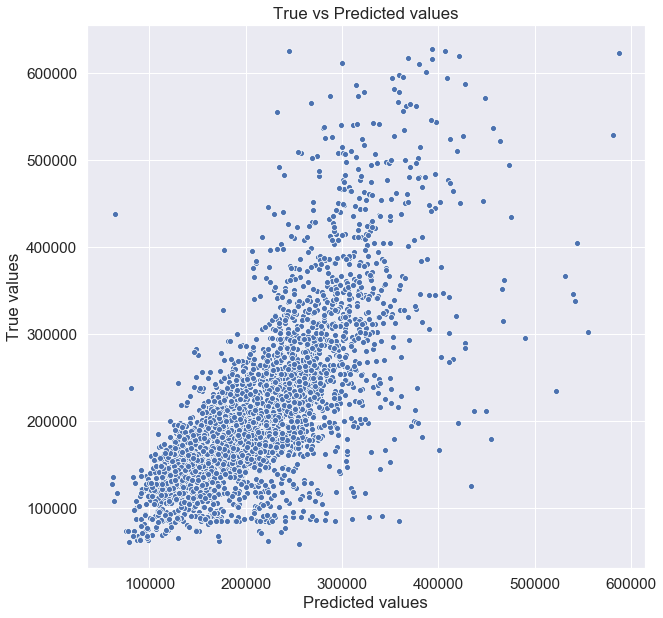

In [139]:
y_test_preds = lasso_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [140]:
ridge_model = Ridge(alpha=0.3)
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

R2:	0.534
MAE:	43592.969
MSE:	3921645513.952


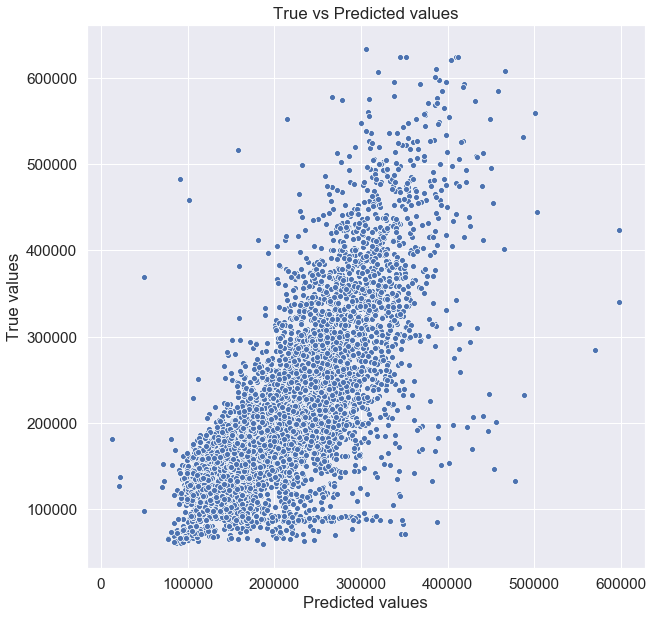

In [141]:
y_train_preds = ridge_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.52
MAE:	45297.031
MSE:	4337737295.773


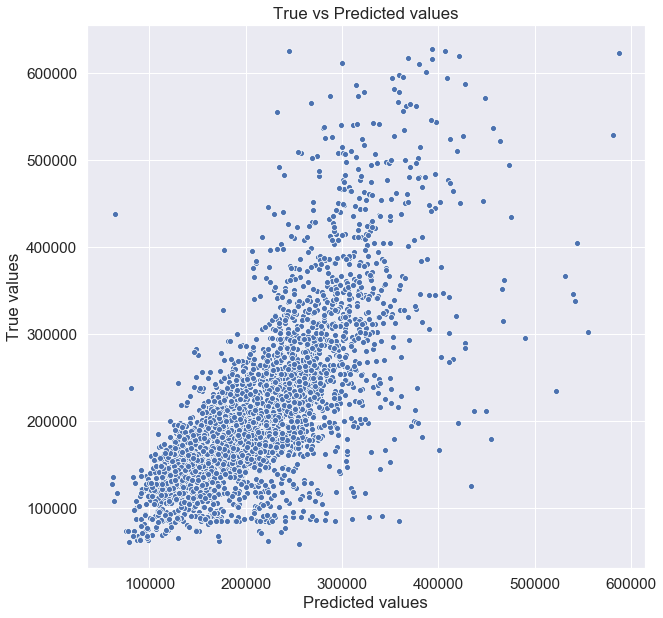

In [142]:
y_test_preds = lasso_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [143]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.948
MAE:	11944.273
MSE:	438835440.96


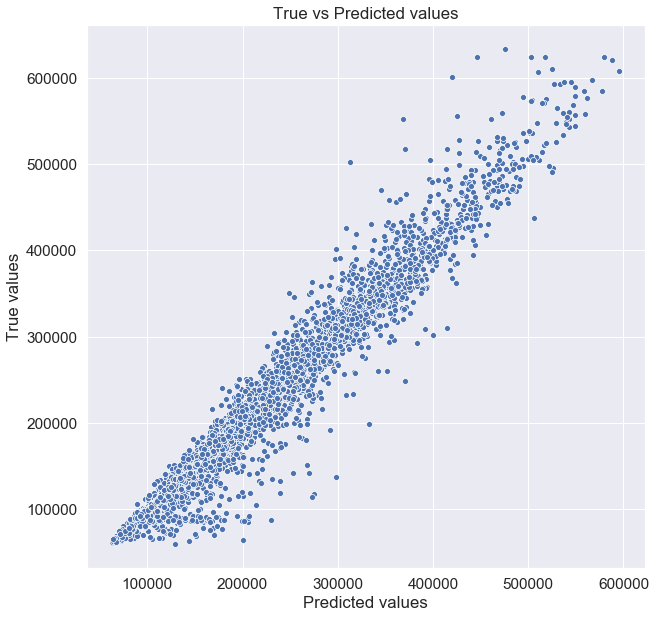

In [144]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.694
MAE:	31548.822
MSE:	2763273360.318


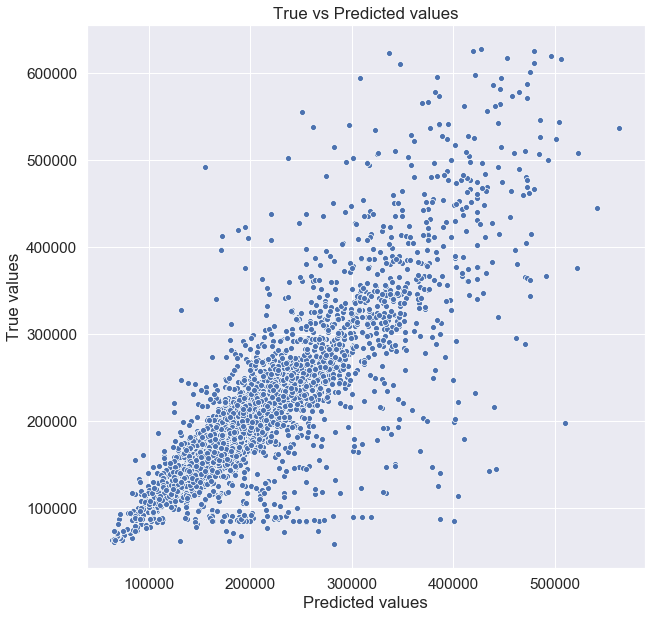

In [145]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [146]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.758
MAE:	28856.395
MSE:	2035002436.898


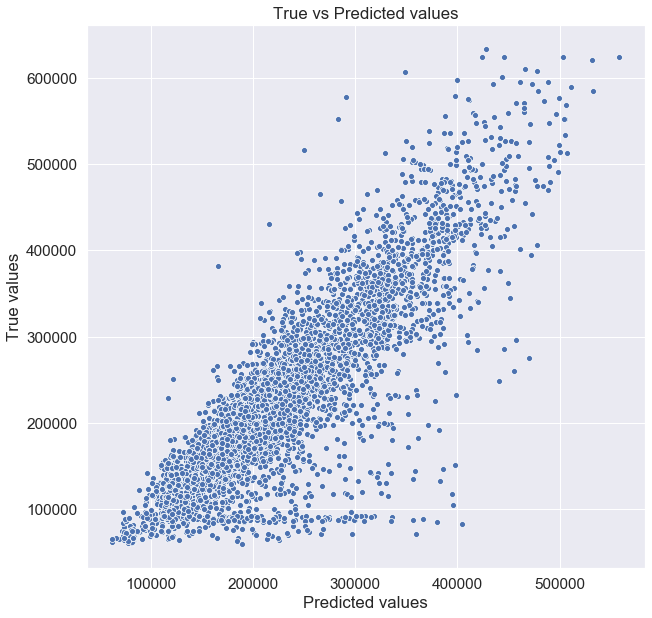

In [147]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.706
MAE:	32177.526
MSE:	2659272198.681


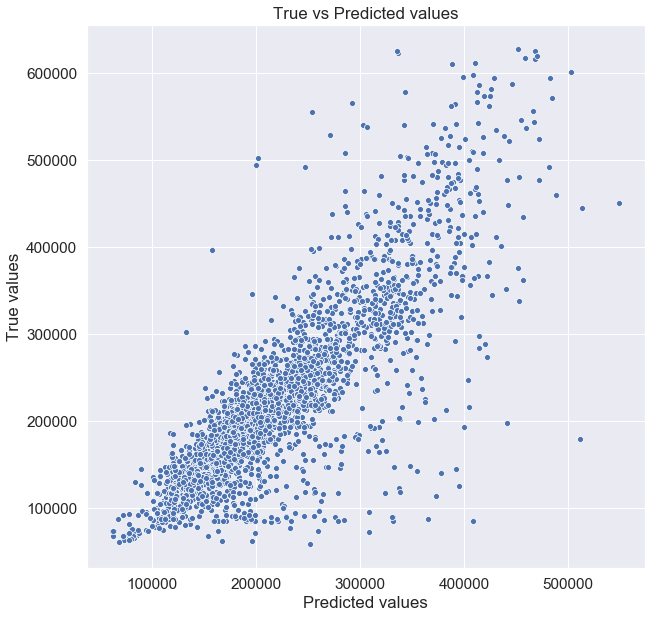

In [148]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [149]:
X_train.dtypes

DistrictId         int64
Rooms              int64
Square           float64
KitchenSquare      int64
Floor              int64
HouseFloor         int64
Ecology_1        float64
Social_1           int64
Social_2           int64
Social_3           int64
Helthcare_2        int64
Shops_1            int64
Ecology_2_A        uint8
Ecology_2_B        uint8
Ecology_3_A        uint8
Ecology_3_B        uint8
Shops_2_A          uint8
Shops_2_B          uint8
dtype: object

In [150]:
y_train.dtypes

dtype('float64')

In [151]:
# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_Y)

# lab_enc = preprocessing.LabelEncoder()
# y_train_encoded = lab_enc.fit_transform(y_train)

# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_encoded)

In [152]:
# log_r_model = LogisticRegression(solver="liblinear")
# log_r_model.fit(X_train, y_train_encoded)

In [153]:
# ? LogisticRegression

In [154]:
# y_train_preds = log_r_model.predict(X_train)
# evaluate_preds(y_train, y_train_preds)

In [155]:
# y_test_preds = log_r_model.predict(X_test)
# evaluate_preds(y_test, y_test_preds)

## Загрузка тестового набора

In [156]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [157]:
test.shape

(5000, 19)

In [158]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [159]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

Количество комнат должно быть целым числом.

In [160]:
test['Rooms'].dtype

dtype('float64')

In [161]:
test['Rooms'] = test['Rooms'].astype('int64')

In [162]:
test['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [163]:
test['HouseFloor'].dtype

dtype('float64')

In [164]:
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [165]:
test['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [166]:
test['KitchenSquare'].dtype

dtype('float64')

In [167]:
test['KitchenSquare'] = test['KitchenSquare'].astype('int64')

In [168]:
test['KitchenSquare'].dtype

dtype('int64')

In [169]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [170]:
len(test) - test.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

**LifeSquare**

In [171]:
for room in test['Rooms'][test['LifeSquare'].isnull()].unique():
    for year in test['HouseYear'][test['LifeSquare'].isnull()].unique():
        for floor in test['HouseFloor'][test['LifeSquare'].isnull()].unique():
            test.loc[test['LifeSquare'].isnull() & (test['Rooms'] == room) & (test['HouseYear'] == year) & (test['HouseFloor'] == floor), 'LifeSquare'] = test['LifeSquare'][test['LifeSquare'].notnull() & (test['Rooms'] == room) & (test['HouseYear'] == year) & (test['HouseFloor'] == floor)].median()

In [172]:
test.loc[test['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
5,7633,53,1,40.675627,NaN,1,21,21,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
158,1755,52,1,39.098603,NaN,10,7,20,2016,0.371149,B,B,34,7065,1,750.0,2,5,B
205,5060,53,2,55.825260,NaN,1,2,19,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
214,5896,62,1,41.274114,NaN,10,3,8,1977,0.072158,B,B,2,629,1,NaN,0,0,A
257,5399,1,3,88.011164,NaN,10,18,22,2016,0.007122,B,B,1,264,0,NaN,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,7130,30,1,46.263117,NaN,1,20,22,2014,0.000078,B,B,22,6398,141,1046.0,3,23,B
4828,5485,62,3,88.098883,NaN,1,14,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A
4907,2024,27,3,108.650465,NaN,1,4,6,1977,0.075424,B,B,11,3097,0,NaN,0,0,B
4922,2515,23,1,49.520325,NaN,1,4,16,2016,0.014073,B,B,2,475,0,NaN,0,0,B


In [173]:
for room in test['Rooms'][test['LifeSquare'].isnull()].unique():
    for year in test['HouseYear'][test['LifeSquare'].isnull()].unique():
        test.loc[test['LifeSquare'].isnull() & (test['Rooms'] == room) & (test['HouseYear'] == year), 'LifeSquare'] = test['LifeSquare'][test['LifeSquare'].notnull() & (test['Rooms'] == room) & (test['HouseYear'] == year)].median()

In [174]:
test.loc[test['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6,110.750226,NaN,0,2,2,2015,0.014073,B,B,2,475,0,NaN,0,0,B


In [175]:
test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = test['LifeSquare'][test['LifeSquare'].notnull()].median()

In [176]:
test.loc[test['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


**Healthcare_1**

"Раскидаем" пустые значения по имеющимся классам значений

Получим уникальные значения из выборки

In [177]:
values = list(test.loc[test['Healthcare_1'].notnull(), 'Healthcare_1'].unique())

In [178]:
values = sorted(values)

In [179]:
length = len(values)

In [180]:
length

79

In [181]:
values[:5]

[0.0, 30.0, 32.0, 35.0, 46.0]

In [182]:
values[length - 5:]

[4087.0, 4129.0, 4508.0, 4702.0, 4849.0]

In [183]:
b = test.loc[test['Healthcare_1'].isnull()]

In [184]:
for id in b['Id']:
    test.loc[test['Id'] == id, 'Healthcare_1'] = values[random.randint(0, length - 1)]

In [185]:
test.loc[test['Healthcare_1'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


**Распределение по комнатам (Rooms)**

In [186]:
test['Rooms'].unique()

array([ 2,  1,  3,  4,  5,  6,  0, 17], dtype=int64)

6,  0, 17 - лишнее

In [187]:
test.loc[test['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0,116.824201,113.692424,0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0,76.345154,42.820796,12,14,0,1977,0.017647,B,B,2,469,0,370.0,0,0,B


In [188]:
test.loc[test['Rooms'] == 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6,110.750226,35.310002,0,2,2,2015,0.014073,B,B,2,475,0,770.0,0,0,B
3217,4058,27,6,223.453689,104.113552,16,2,2,2017,0.041116,B,B,53,14892,4,1894.0,1,4,B


In [189]:
test.loc[test['Rooms'] == 17]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3398,1435,111,17,52.866107,32.528342,8,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [190]:
test.loc[test['Id'] == 3343, 'Rooms'] = 5

In [191]:
test.loc[test['Id'] == 10729, 'Rooms'] = 3

In [192]:
test.loc[test['Id'] == 10793, 'Rooms'] = 5

In [193]:
test.loc[test['Id'] == 4058, 'Rooms'] = 5

In [194]:
test.loc[test['Id'] == 1435, 'Rooms'] = 1

**Общая площадь квартиры (Square)**

In [195]:
test.sort_values(by="Square", inplace=True)

In [196]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
66,9011,53,1,1.378543,1.353573,1,1,1,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
4902,1420,45,1,1.975769,2.900371,1,1,1,1977,0.195781,B,B,23,5212,6,80.0,3,2,B
4490,1165,27,1,2.372101,1.899119,1,2,17,1977,0.011654,B,B,4,915,0,770.0,0,0,B
608,16401,30,1,2.645046,4.338755,1,2,1,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
4713,170,6,2,2.900586,61.468563,1,18,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,3357,27,3,170.476326,75.973612,8,2,2,2017,0.041116,B,B,53,14892,4,2500.0,1,4,B
1264,13589,27,3,173.974480,76.289475,9,3,3,2017,0.041116,B,B,53,14892,4,176.0,1,4,B
1499,7769,124,4,189.679576,114.708673,4,19,40,2013,0.174739,B,B,17,3379,9,100.0,0,3,B
3909,1397,76,3,221.138768,118.055342,4,32,48,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B


**Жилая площадь (LifeSquare)**

In [197]:
test.sort_values(by="LifeSquare", inplace=True)

In [198]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
78,6553,34,5,122.375273,0.333490,0,9,0,1977,0.069753,B,B,53,13670,4,1937.0,1,11,B
2992,6406,27,2,66.469510,0.567267,0,4,0,2018,0.017647,B,B,2,469,0,145.0,0,0,B
2341,3028,9,1,43.348348,0.809265,0,16,17,2015,0.161532,B,B,25,5648,1,30.0,2,4,B
2398,13014,53,3,81.141636,0.863989,0,10,1,2017,0.049637,B,B,34,7759,0,229.0,1,3,B
326,14959,1,2,64.112441,1.181139,1,13,17,1977,0.007122,B,B,1,264,0,145.0,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,2198,54,3,125.401265,128.913470,1,7,1,2016,0.006076,B,B,30,5285,0,645.0,6,6,B
2126,16531,93,3,136.389391,136.689191,0,1,1,1977,0.004949,B,B,0,186,0,1020.0,0,0,B
2081,1686,62,3,137.653211,136.921090,0,4,3,1977,0.072158,B,B,2,629,1,1786.0,0,0,A
2557,16053,17,4,168.729035,169.901701,0,4,0,2013,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [199]:
test.loc[test['Id'] == 11533, 'LifeSquare'] = 30

**Кухня (KitchenSquare)**

In [200]:
test.sort_values(by="KitchenSquare", inplace=True)

In [201]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
78,6553,34,5,122.375273,0.333490,0,9,0,1977,0.069753,B,B,53,13670,4,1937.0,1,11,B
3672,1474,74,1,48.031878,41.832877,0,7,0,1977,0.075779,B,B,6,1437,3,1046.0,0,2,B
2827,4659,74,1,52.103243,41.832877,0,8,0,1977,0.075779,B,B,6,1437,3,262.0,0,2,B
4564,211,27,1,44.783510,41.832877,0,5,0,1977,0.072158,B,B,2,629,1,800.0,0,0,A
4460,9535,1,1,48.460912,41.832877,0,13,0,1977,0.007122,B,B,1,264,0,370.0,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,8015,27,1,66.099096,33.639611,62,3,7,2016,0.014058,B,B,1,290,0,990.0,0,0,B
1456,5260,73,3,69.358242,51.247581,65,6,6,1931,0.042032,B,B,37,6856,84,1940.0,2,5,B
4555,12640,6,2,54.629142,31.486308,97,4,17,2015,0.243205,B,B,5,1564,0,540.0,0,0,B
1777,3341,62,3,112.114019,112.247841,112,3,3,2017,0.072158,B,B,2,629,1,80.0,0,0,A


In [202]:
id_list = list(test.loc[test['KitchenSquare'] > 25, 'Id'])

In [203]:
for id in id_list:
    rooms = list(test['Rooms'][test['Id'] == id])[0]
    floor = list(test['HouseFloor'][test['Id'] == id])[0]
    result = test['KitchenSquare'][(test['Rooms'] == rooms) & (test['HouseFloor'] == floor) & (test['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        test.loc[test['Id'] == id, 'KitchenSquare'] = round(result,0)

In [204]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
78,6553,34,5,122.375273,0.333490,0.0,9,0,1977,0.069753,B,B,53,13670,4,1937.0,1,11,B
3672,1474,74,1,48.031878,41.832877,0.0,7,0,1977,0.075779,B,B,6,1437,3,1046.0,0,2,B
2827,4659,74,1,52.103243,41.832877,0.0,8,0,1977,0.075779,B,B,6,1437,3,262.0,0,2,B
4564,211,27,1,44.783510,41.832877,0.0,5,0,1977,0.072158,B,B,2,629,1,800.0,0,0,A
4460,9535,1,1,48.460912,41.832877,0.0,13,0,1977,0.007122,B,B,1,264,0,370.0,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,8015,27,1,66.099096,33.639611,9.0,3,7,2016,0.014058,B,B,1,290,0,990.0,0,0,B
1456,5260,73,3,69.358242,51.247581,8.0,6,6,1931,0.042032,B,B,37,6856,84,1940.0,2,5,B
4555,12640,6,2,54.629142,31.486308,9.0,4,17,2015,0.243205,B,B,5,1564,0,540.0,0,0,B
1777,3341,62,3,112.114019,112.247841,3.0,3,3,2017,0.072158,B,B,2,629,1,80.0,0,0,A


**Этаж (Floor)**

In [205]:
test.sort_values(by="Floor", inplace=True)

In [206]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1857,6611,99,2,44.594325,31.894068,5.0,1,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B
2219,10148,69,2,53.807445,30.943436,7.0,1,9,1972,0.000991,B,B,33,6783,3,350.0,1,9,B
1646,12374,84,3,80.510899,53.211190,8.0,1,5,1953,0.149666,B,B,22,4789,2,4087.0,4,1,B
2286,11491,54,1,78.181873,75.203901,1.0,1,15,2017,0.006076,B,B,30,5285,0,645.0,6,6,B
3523,16444,31,1,32.731195,15.019807,8.0,1,5,1964,0.151346,B,A,32,5889,10,830.0,4,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585,4533,31,2,83.963299,38.419224,14.0,33,40,2014,0.151346,B,A,32,5889,10,830.0,4,1,B
4764,2461,72,2,103.114357,4.312838,1.0,34,37,2015,0.210473,B,B,11,2398,2,1994.0,3,0,B
1587,5707,76,2,73.363523,38.740060,5.0,38,48,2010,0.000000,B,B,7,1660,39,1786.0,1,5,B
3711,414,76,2,67.609808,41.175948,5.0,46,48,2002,0.000000,B,B,7,1660,39,1786.0,1,5,B


In [207]:
test.loc[test['Id'] == 15759, 'Floor'] = 78

**Этажность дома (HouseFloor)**

In [208]:
test.sort_values(by="HouseFloor", inplace=True)

In [209]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4664,1736,27,1,51.492952,41.832877,0.0,5,0,1977,0.072158,B,B,2,629,1,770.0,0,0,A
2425,12512,27,1,40.950673,41.832877,0.0,2,0,1977,0.017647,B,B,2,469,0,3855.0,0,0,B
772,902,27,3,99.293191,86.540359,0.0,2,0,1977,0.075424,B,B,11,3097,0,1575.0,0,0,B
4798,208,62,2,76.048201,60.727617,0.0,2,0,1977,0.072158,B,B,2,629,1,46.0,0,0,A
113,5032,30,1,50.738045,41.832877,0.0,5,0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,7769,124,4,189.679576,114.708673,4.0,19,40,2013,0.174739,B,B,17,3379,9,100.0,0,3,B
3909,1397,76,3,221.138768,118.055342,4.0,32,48,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
1587,5707,76,2,73.363523,38.740060,5.0,38,48,2010,0.000000,B,B,7,1660,39,1786.0,1,5,B
3711,414,76,2,67.609808,41.175948,5.0,46,48,2002,0.000000,B,B,7,1660,39,1786.0,1,5,B


In [210]:
test.loc[test['Id'] == 15864, 'HouseFloor'] = 18

**Год постройки (HouseYear)**

In [211]:
test.sort_values(by="HouseYear", inplace=True)

In [212]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3253,12316,183,5,157.976101,101.040485,12.0,7,8,1908,0.246624,B,B,14,2940,45,35.0,3,6,B
2,5480,190,1,13.597819,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
2691,9076,60,3,61.400464,38.591813,8.0,5,5,1910,0.341072,B,B,27,5664,48,2300.0,3,11,B
64,3726,161,1,52.708494,20.502345,11.0,3,7,1911,0.014423,B,B,19,3806,4,520.0,0,3,B
1475,16217,206,4,76.428426,50.344903,11.0,7,6,1912,0.042032,B,B,37,6856,84,1940.0,2,5,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382,651,53,1,40.108538,21.984746,8.0,12,24,2020,0.049637,B,B,34,7759,0,229.0,1,3,B
888,8560,37,2,57.979074,41.758328,10.0,7,20,2020,0.178917,B,B,18,3594,4,192.0,1,5,B
4273,8311,53,1,38.747897,21.602020,8.0,15,24,2020,0.049637,B,B,34,7759,0,229.0,1,3,B
4777,16098,62,2,64.481854,36.653054,9.0,12,14,2020,0.072158,B,B,2,629,1,200.0,0,0,A


### Отбор и построение новых признаков

In [213]:
id_list = list(test.loc[test['Id'].notnull(), 'Id'])

In [214]:
# for id in id_list:
#     district = list(test['DistrictId'][test['Id'] == id])[0]
#     rooms = list(test['Rooms'][test['Id'] == id])[0]
#     floor = list(test['HouseFloor'][test['Id'] == id])[0]
#     result = train_add['Square_Price'][(train_add['DistrictId'] == district) & (train_add['Rooms'] == rooms) & (train_add['HouseFloor'] == floor) & (test['HouseYear'] != 1977)].median()
#     if pd.notnull(result):
#         test.loc[test['Id'] == id, 'Square_Price'] = result

In [215]:
# len(test) - test.count()

In [216]:
# id_list = list(test.loc[test['Square_Price'].isnull(), 'Id'])

In [217]:
# for id in id_list:
#     district = list(test['DistrictId'][test['Id'] == id])[0]
#     rooms = list(test['Rooms'][test['Id'] == id])[0]
#     result = train_add['Square_Price'][(train_add['DistrictId'] == district) & (train_add['Rooms'] == rooms) & (test['HouseYear'] != 1977)].median()
#     if pd.notnull(result):
#         test.loc[test['Id'] == id, 'Square_Price'] = result

In [218]:
len(test) - test.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [219]:
# id_list = list(test.loc[test['Square_Price'].isnull(), 'Id'])

In [220]:
# for id in id_list:
#     rooms = list(test['Rooms'][test['Id'] == id])[0]
#     result = train_add['Square_Price'][(train_add['Rooms'] == rooms) & (test['HouseYear'] != 1977)].median()
#     if pd.notnull(result):
#         test.loc[test['Id'] == id, 'Square_Price'] = result

In [221]:
# len(test) - test.count()

In [222]:
test.sort_values(by="Id", inplace=True)

In [223]:
test = pd.concat([test, pd.get_dummies(test['Ecology_2'], prefix='Ecology_2')], axis=1)

In [224]:
test = pd.concat([test, pd.get_dummies(test['Ecology_3'], prefix='Ecology_3')], axis=1)

In [225]:
test = pd.concat([test, pd.get_dummies(test['Shops_2'], prefix='Shops_2')], axis=1)

In [226]:
test.drop(['Ecology_2'],axis=1,inplace=True)

In [227]:
test.drop(['Ecology_3'],axis=1,inplace=True)

In [228]:
test.drop(['Shops_2'],axis=1,inplace=True)

In [229]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
4422,1,1,2,83.061098,83.830248,0.0,10,22,1977,0.007122,...,0,165.0,0,1,0,1,0,1,0,1
979,3,3,1,30.185483,14.810573,6.0,4,9,1970,0.265089,...,0,1937.0,3,2,0,1,0,1,0,1
4157,4,4,1,37.294669,17.165597,8.0,9,9,1970,0.327018,...,23,2500.0,1,0,0,1,0,1,0,1
712,8,8,3,83.930342,50.049315,8.0,4,12,2007,0.092291,...,2,165.0,1,2,0,1,0,1,0,1
4394,9,6,1,38.800420,42.560690,1.0,3,17,2017,0.243205,...,0,540.0,0,0,0,1,0,1,0,1


In [230]:
df_test = test[feature_names]
df_test.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
4422,1,2,83.061098,0.0,10,22,0.007122,1,264,0,0,1,0,1,0,1,0,1
979,3,1,30.185483,6.0,4,9,0.265089,37,5288,0,3,2,0,1,0,1,0,1
4157,4,1,37.294669,8.0,9,9,0.327018,12,2270,23,1,0,0,1,0,1,0,1
712,8,3,83.930342,8.0,4,12,0.092291,21,4346,2,1,2,0,1,0,1,0,1
4394,6,1,38.800420,1.0,3,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1


In [231]:
feature_names_for_stand = df_test[feature_names].select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1']

In [232]:
# stand_features_test = scaler.fit_transform(df_test[feature_names_for_stand])
stand_features_test = df_test

In [233]:
stand_features_test

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
4422,1,2,83.061098,0.0,10,22,0.007122,1,264,0,0,1,0,1,0,1,0,1
979,3,1,30.185483,6.0,4,9,0.265089,37,5288,0,3,2,0,1,0,1,0,1
4157,4,1,37.294669,8.0,9,9,0.327018,12,2270,23,1,0,0,1,0,1,0,1
712,8,3,83.930342,8.0,4,12,0.092291,21,4346,2,1,2,0,1,0,1,0,1
4394,6,1,38.800420,1.0,3,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,55,3,78.688848,8.0,12,14,0.041365,31,5569,0,1,4,0,1,0,1,0,1
4355,74,1,48.763155,1.0,7,10,0.075779,6,1437,3,0,2,0,1,0,1,0,1
4897,128,2,56.856093,8.0,9,14,0.041116,53,14892,4,1,4,0,1,0,1,0,1
1908,26,1,36.802779,5.0,4,9,0.000000,36,6714,2,0,2,0,1,0,1,0,1


In [234]:
df_test[feature_names_for_stand] = pd.DataFrame(stand_features_test, columns=feature_names_for_stand)

In [235]:
df_test

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
4422,1,2,83.061098,0.0,10,22,0.007122,1,264,0,0,1,0,1,0,1,0,1
979,3,1,30.185483,6.0,4,9,0.265089,37,5288,0,3,2,0,1,0,1,0,1
4157,4,1,37.294669,8.0,9,9,0.327018,12,2270,23,1,0,0,1,0,1,0,1
712,8,3,83.930342,8.0,4,12,0.092291,21,4346,2,1,2,0,1,0,1,0,1
4394,6,1,38.800420,1.0,3,17,0.243205,5,1564,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,55,3,78.688848,8.0,12,14,0.041365,31,5569,0,1,4,0,1,0,1,0,1
4355,74,1,48.763155,1.0,7,10,0.075779,6,1437,3,0,2,0,1,0,1,0,1
4897,128,2,56.856093,8.0,9,14,0.041116,53,14892,4,1,4,0,1,0,1,0,1
1908,26,1,36.802779,5.0,4,9,0.000000,36,6714,2,0,2,0,1,0,1,0,1


In [236]:
X_test = df_test[feature_names]

In [237]:
y_test_preds = rf_model.predict(X_test)

In [238]:
y_test_preds

array([239017.13883586, 143310.29829911, 200565.82139679, ...,
       249132.2503187 , 162571.22253964, 184244.76334553])

In [239]:
df_res = pd.DataFrame({'Id':list(test['Id']),'Price':list(y_test_preds)})

In [240]:
df_res.to_csv(DF_TEST_RESULT_DATASET_PATH, index=False, encoding='utf-8')